# CDIP Web Scraper

In [1]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


### Import packages

In [2]:
import pandas as pd
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import datetime
import time
from matplotlib import gridspec

### Constants

In [3]:
# TODO: load station number and yeardate based on smartfin ride date input
from smartfin_web_scraper import Ride

ride = Ride(ride_id='15692', data='motion')
start_date, end_date = ride.get_ride_timeframe()

# station number <- temporary values
stn = '067'

# CDIP Archived Dataset URL
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_historic.nc'
data_url

fetching ride from:  https://surf.smartfin.org/ride/15692
fetching motion data from:  https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Motion.CSV


'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/067p1/067p1_historic.nc'

### Read vars from CDIP THREDDS Server Dataset

In [4]:
# netCDF data object fetched from CDIP API
nc = netCDF4.Dataset(data_url)

# UNIX based time from 1991-yeardate in 30 minute increments
ncTime = nc.variables['sstTime'][:]
timeall = [datetime.datetime.fromtimestamp(t) for t in ncTime]

# wave heights
Hs = nc.variables['waveHs']


In [5]:
# Find nearest value in ncTime array to inputted UNIX Timestamp
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    print(idx)
    return array[idx]

### Convert human time to UNIX time

In [6]:
# Convert human-formatted date to UNIX timestamp
def getUnixTimestamp(humanTime,dateFormat):
    unixTimestamp = int(time.mktime(datetime.datetime.strptime(humanTime, dateFormat).timetuple()))
    print('humanTime: ', humanTime)
    print('UNIX Timestamp: ', unixTimestamp)
    return unixTimestamp

## Time Index Values

Find the UNIX values that correspond to start (Day 1) and end (Day 28) dates for each month. Then find the array index numbers for each UNIX value within the 'ncTime' arrays.

In [7]:
# # Create array of lists of Hs data for each month 

# timeindex_start = []
# timeindex_end = []
# monthcount = 0

unixstart = getUnixTimestamp(start_date,"%m/%d/%Y %H:%M:%S")
nearest_date = find_nearest(ncTime, unixstart)  # Find the closest unix timestamp
start_index = np.where(ncTime==nearest_date)[0][0]  # Grab the index number of found date

unixend = getUnixTimestamp(end_date,"%m/%d/%Y %H:%M:%S")
future_date = find_nearest(ncTime, unixend)  # Find the closest unix timestamp
end_index = np.where(ncTime==future_date)[0][0]  # Grab the index number of found date    

print(nearest_date)
print(future_date)

# timeindex_start.append(start_index) # Append 'month start date' and 'month end date' index numbers for each month to corresponding array
# timeindex_end.append(end_index)


humanTime:  09/11/2018 19:16:03
UNIX Timestamp:  1536718563
309100
humanTime:  09/11/2018 20:38:15
UNIX Timestamp:  1536723495
309103
1536717765
1536723165


### Calculate mean wave heights of each month

Create array of month-long chunks of Hs data, to be plotted as a series of boxplots. Use a for-loop to cycle through the Hs variable and define each month-long array using the above-specified time index numbers.

In [24]:
box_data = []
i = 0
print(start_index - end_index)
    
# all wave height averages per 30 minute increments over each month
ride_hs = Hs[start_index:end_index]
i = i+1
print(len(ride_hs))
print(ride_hs)
    
# append each dataset to the box data
box_data.append(ride_hs)
    
# calculate means of each month dataset in box_data
means = np.asarray([np.mean(m) for m in box_data]) 

# Round each monthly mean value to 2 decimal points, for plotting
meansround = [round(k,2) for k in means] 
print(means)
print(ride_hs.mean())
print('mean wave height:', meansround)
ride_hs.data

-3
3
[2.3  2.15 2.04]
[2.1633332]
2.1633332
mean wave height: [2.16]


array([2.3 , 2.15, 2.04], dtype=float32)

Calculate the number of instances of the variable being incorporated into each month-long average

In [9]:
monthlengths = []
j = 0

for Hsj in range(len(Hs[timeindex_start])):
    
    # how many readings were recorded during that month
    monthlenHs = len(Hs[timeindex_start[j]:timeindex_end[j]])
    j = j+1
    monthlengths.append(monthlenHs)
    
monthlengths

[3]

## Plot Wave Time-Series
* Create boxplot graph of month-long datasets
* Each box includes:
    - Median (red line)
    - 25th and 75th percentiles (top and bottom of box)
    - Remaining data within 1.5L above and below (whiskers) the quartiles, where L = length (m) from 25th to 75th percentile
    - Outliers (red crosses) - data beyond whiskers
    - Mean position (green line) and value (green number)
* Adjust colors and labels of graphical display
* Include a second plot of a sample 'legend' boxplot

ValueError: x and y must be the same size

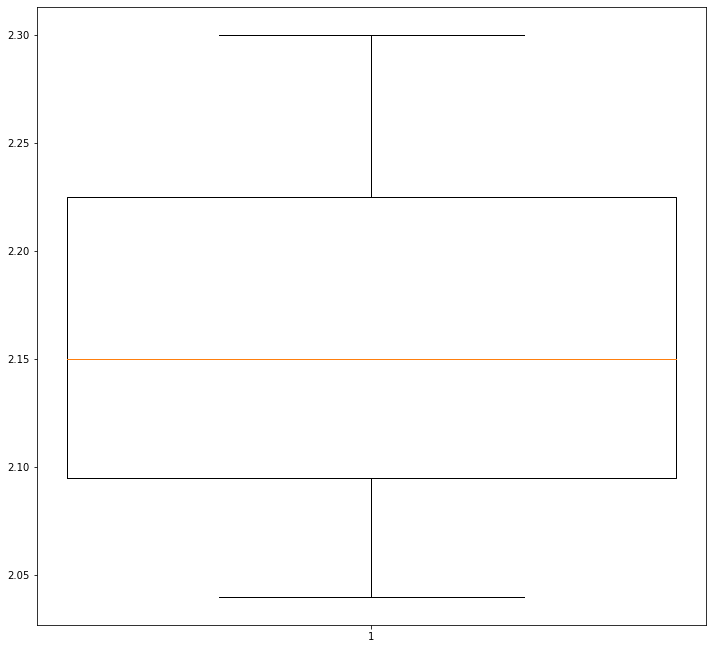

In [10]:
# Create overall figure and specify size, and grid to specify positions of subplots
fig = plt.figure(figsize=(12,15)) 
gs = gridspec.GridSpec(2,2,height_ratios=[5,1]) 


# Create a dataset for sample 'legend' boxplot, to go underneath actual boxplot
bp_sample2 = np.random.normal(2.5,0.5,500)


# Create two subplots - actual monthly-averaged data (top) and example 'legend' boxplot (bottom)

# Subplot of monthly-averaged boxplot data
bp = plt.subplot(gs[0,:])
bp_data = bp.boxplot(box_data) # Add 'meanlineprops' to include the above-defined properties
bp.scatter(months,means,marker="_",color='g',linewidths=2.5,s=900) # Overlay monthly means as green lines using 'scatter' function.

# Subplot to show example 'legend' boxplot below actual monthly-averaged boxplot graph
bp2 = plt.subplot(gs[1,1:-1])
bp2_example = bp2.boxplot(bp_sample2,vert=False) # Plot horizontal example boxplot with labels
bp2.scatter(2.3,1,marker="|",color='g',linewidths=2.5,s=400)


# Add values of monthly means as text
for i, txt in enumerate(meansround):
    bp.annotate(txt, (months[i],means[i]),fontsize=12,horizontalalignment='center',verticalalignment='bottom',color='g')

    
# Get positions of Median, Quartiles and Outliers to use in 'legend' text labels 
for line in bp2_example['medians']:
    xm, ym = line.get_xydata()[0] # location of Median line   
for line in bp2_example['boxes']:
    xb, yb = line.get_xydata()[0] # location of Box edges (Quartiles)
for line in bp2_example['whiskers']:
    xw, yw = line.get_xydata()[0] # location of Whisker ends (Outliers)
    

# Add text labels for 'Median', Mean', '25th/75th %iles' and 'Outliers' to subplot2, to create sample 'legend' boxplot
bp2.annotate("Median",[xm,ym-0.3*ym],fontsize=14,color='r')
bp2.annotate("Mean",[2.2,0.65],fontsize=14,color='g')
bp2.annotate("25%ile",[xb-0.01*xb,yb-0.15*yb],fontsize=12)
bp2.annotate("75%ile",[xb+0.2*xb,yb-0.15*yb],fontsize=12)
bp2.annotate("Outliers",[xw+0.38*xw,yw-0.3*yw],fontsize=14,color='r')

 
# Set colors of box aspects for top subplot    
pylab.setp(bp_data['boxes'], color='black')
pylab.setp(bp_data['whiskers'], color='black')
pylab.setp(bp_data['fliers'], color='r')


# Set colors of box aspects for bottom (sample) subplot   
pylab.setp(bp2_example['boxes'], color='black')
pylab.setp(bp2_example['whiskers'], color='black')
pylab.setp(bp2_example['fliers'], color='r')


# Set Titles
plt.suptitle(buoytitle, fontsize=30, y=0.97) # Overall plot title using 'buoytitle' variable
bp.set_title("Significant Wave Height by month for " + year_date, fontsize=20, y=1.01) # Subtitle for top plot
# bp2.set_title("Sample Boxplot", fontsize=16, y=1.02) # Subtitle for bottom plot


# Set axes labels and ticks
bp.set_xticklabels(['ride'],fontsize=12)
bp.set_ylabel('Significant Wave Height, Hs (m)', fontsize=20)
bp.tick_params(axis='y', which='major', labelsize=12, right='off')
bp.tick_params(axis='x', which='major', labelsize=12, top='off')


# Create a second row of x-axis labels for top subplot
newax = bp.twiny()
newax.xaxis.set_ticks_position('bottom')
newax.xaxis.set_label_position('bottom')
newax.spines['bottom'].set_position(('outward',25))
newax.set_xticklabels(monthlengths,fontsize=10)


# Plot horizontal gridlines onto top subplot
bp.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)


# Remove tickmarks from bottom subplot
bp2.axes.get_xaxis().set_visible(False)
bp2.axes.get_yaxis().set_visible(False)